<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/narmax_activity_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution 1: ARX Model Term Selection (OLS)

This notebook solves the first activity from `narmax_activities.md`. It uses the Orthogonal Least Squares (OLS) method to select the most relevant terms for an ARX model based on the Error Reduction Ratio (ERR).

In [ ]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv, solve

## Helper Functions

In [ ]:
def load_mat_file(file_url):
    local_filename = os.path.basename(file_url)
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        os.system(f"wget -q -O {local_filename} '{file_url}'")
    mat_data = scipy.io.loadmat(local_filename)
    return mat_data['u'], mat_data['y']

def get_term_name(index, ny, nu):
    if index < ny:
        return f"y(k-{index+1})"
    else:
        return f"u(k-{index-ny+1})"

def build_regression_matrix(u, y, ny, nu):
    N = len(y)
    max_lag = max(ny, nu)
    P = np.zeros((N - max_lag, ny + nu))
    for i in range(max_lag, N):
        y_lags = y[np.arange(i-1, i-ny-1, -1)].flatten()
        u_lags = u[np.arange(i-1, i-nu-1, -1)].flatten()
        P[i - max_lag, :] = np.hstack([y_lags, u_lags])
    Y = y[max_lag:]
    return P, Y

def MGS(P):
    n_rows, n_cols = P.shape
    A = np.eye(n_cols, dtype=float)
    P_curr = P.astype(float)
    Q = np.zeros_like(P_curr, dtype=float)
    for i in range(n_cols):
        Q[:, i] = P_curr[:, i]
        for j in range(i + 1, n_cols):
            q_i_norm_sq = Q[:, i].T @ Q[:, i]
            if q_i_norm_sq > 1e-18:
                A[i, j] = (Q[:, i].T @ P_curr[:, j]) / q_i_norm_sq
                P_curr[:, j] = P_curr[:, j] - A[i, j] * Q[:, i]
    return Q, A

def ols(P, Y_target, ny, nu):
    niter = P.shape[1]
    W, A = MGS(P)
    g = np.zeros(niter)
    for i in range(niter):
        g[i] = (Y_target.T @ W[:, i]).item() / (W[:, i].T @ W[:, i]).item()
    g = g.reshape(-1, 1)
    ERR = np.zeros(niter)
    for i in range(niter):
        ERR[i] = ((Y_target.T @ W[:, i]).item()**2) / ((Y_target.T @ Y_target).item() * (W[:, i].T @ W[:, i]).item())
    ESR = 1 - np.sum(ERR)
    th_OLS = solve(A, g)
    return th_OLS, ERR, ESR

class ARX_OLS:
    def __init__(self, ny, nu, rho=0.01):
        self.ny = ny
        self.nu = nu
        self.rho = rho
        self.theta = None
        self.selected_terms = None
        self.selected_terms_info = [] # To store info for printing table

    def fit(self, u, y):
        P, Y = build_regression_matrix(u, y, self.ny, self.nu)
        _, ERR, _ = ols(P, Y, self.ny, self.nu)

        sorted_indices = np.argsort(ERR)[::-1]
        cumulative_err = 0
        selected_indices = []
        self.selected_terms_info = [] # Reset for each fit

        if self.rho > 0 and self.rho < 1: # rho is a percentage
            target_err = 1 - self.rho
            for index in sorted_indices:
                if cumulative_err < target_err:
                    selected_indices.append(index)
                    cumulative_err += ERR[index]
                    term_name = get_term_name(index, self.ny, self.nu)
                    self.selected_terms_info.append({'name': term_name, 'err': ERR[index], 'original_index': index})
        elif self.rho >= 1: # rho is a fixed number of terms
            num_terms_to_select = int(self.rho)
            for i in range(min(num_terms_to_select, len(sorted_indices))):
                index = sorted_indices[i]
                selected_indices.append(index)
                cumulative_err += ERR[index]
                term_name = get_term_name(index, self.ny, self.nu)
                self.selected_terms_info.append({'name': term_name, 'err': ERR[index], 'original_index': index})

        self.selected_terms = sorted(selected_indices)
        P_selected = P[:, self.selected_terms]
        self.theta, _, _ = ols(P_selected, Y, self.ny, self.nu)

    def print_model_summary(self):
        print("Selected Terms and ERR:")
        print("----------------------------------------------------")
        print(f"{'Term':<15}{'ERR (%)':>10}{'Coefficient':>20}")
        print("----------------------------------------------------")

        sorted_selected_terms_info = sorted(self.selected_terms_info, key=lambda x: x['err'], reverse=True)

        for term_info in sorted_selected_terms_info:
            try:
                theta_index = self.selected_terms.index(term_info['original_index'])
                coeff = self.theta[theta_index].item()
            except ValueError:
                coeff = np.nan # Should not happen if logic is correct

            print(f"{term_info['name']:<15}{term_info['err']*100:>10.6f}{coeff:>20.2e}")
        print("----------------------------------------------------")

        model_equation = "y(k) = "
        for i, original_idx in enumerate(self.selected_terms):
            coeff = self.theta[i].item()
            term_name = get_term_name(original_idx, self.ny, self.nu)
            if coeff >= 0 and i > 0:
                model_equation += " + "
            elif coeff < 0:
                model_equation += " - "
            model_equation += f"{abs(coeff):.2e} * {term_name}"
        print("Model Equation:")
        print(model_equation)

    def predict(self, u, y, prediction_type='OSA'):
        P, _ = build_regression_matrix(u, y, self.ny, self.nu)
        P_selected = P[:, self.selected_terms]
        N = len(u)
        y_hat = np.zeros(N)
        max_lag = max(self.ny, self.nu)

        if prediction_type == 'OSA':
            y_hat[max_lag:] = (P_selected @ self.theta).flatten()
        elif prediction_type == 'FR':
            y_hat_fr = np.zeros(N)
            for k in range(max_lag, N):
                y_lags = y_hat_fr[np.arange(k-1, k-self.ny-1, -1)].flatten()
                u_lags = u[np.arange(k-1, k-self.nu-1, -1)].flatten()
                regressors = np.hstack([y_lags, u_lags])
                selected_regressors = regressors[self.selected_terms]
                y_hat_fr[k] = (selected_regressors @ self.theta).item()
            y_hat = y_hat_fr
        return y_hat

## Data Loading and Visualization

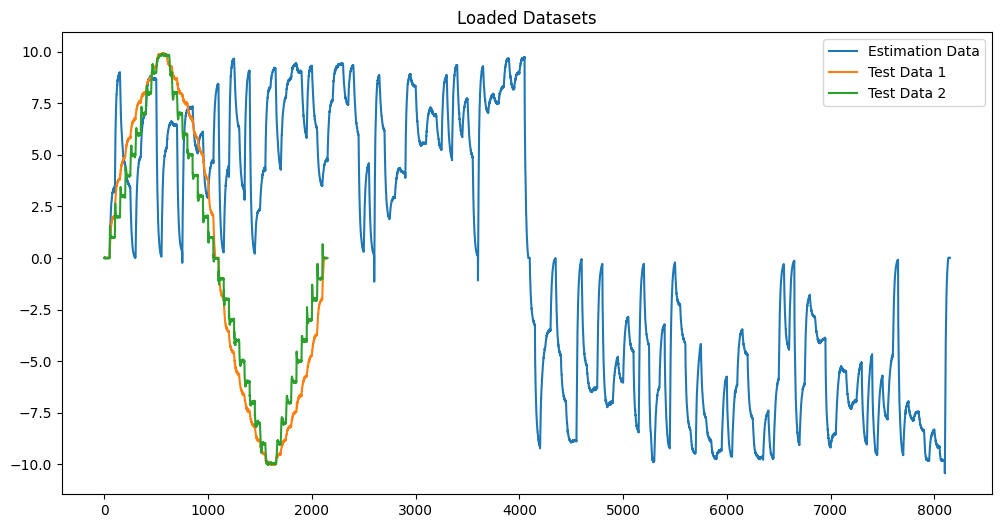

In [ ]:
estimation_url = 'https://github.com/helonayala/sysid/raw/main/data/randomStepSequence.mat'
test_url_1 = 'https://github.com/helonayala/sysid/raw/main/data/fixedStepSequence.mat'
test_url_2 = 'https://github.com/helonayala/sysid/raw/main/data/closedLoop.mat'

u_est, y_est = load_mat_file(estimation_url)
u_test1, y_test1 = load_mat_file(test_url_1)
u_test2, y_test2 = load_mat_file(test_url_2)

plt.figure(figsize=(12, 6))
plt.plot(y_est, label='Estimation Data')
plt.plot(y_test1, label='Test Data 1')
plt.plot(y_test2, label='Test Data 2')
plt.title('Loaded Datasets')
plt.legend()
plt.show()

## Model Training and Evaluation

In [ ]:
mdl = ARX_OLS(ny=10, nu=10, rho=5)
mdl.fit(u_est, y_est)
mdl.print_model_summary()


Selected Terms and ERR:
----------------------------------------------------
Term              ERR (%)         Coefficient
----------------------------------------------------
y(k-1)          99.958062            1.19e+00
y(k-2)           0.015227            4.42e-02
u(k-1)           0.004246            6.79e-01
y(k-3)           0.003861           -2.55e-01
u(k-2)           0.001047           -3.87e-01
----------------------------------------------------
Model Equation:
y(k) = 1.19e+00 * y(k-1) + 4.42e-02 * y(k-2) - 2.55e-01 * y(k-3) + 6.79e-01 * u(k-1) - 3.87e-01 * u(k-2)


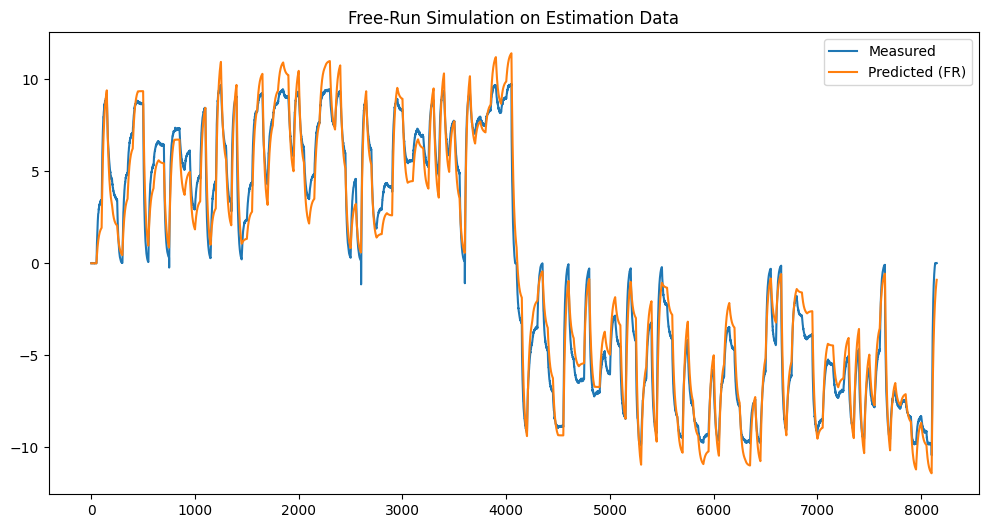

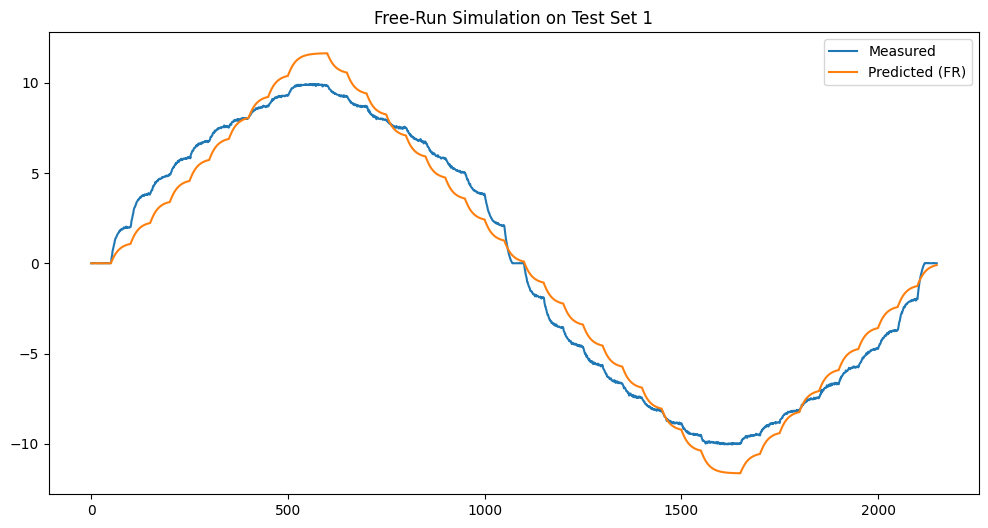

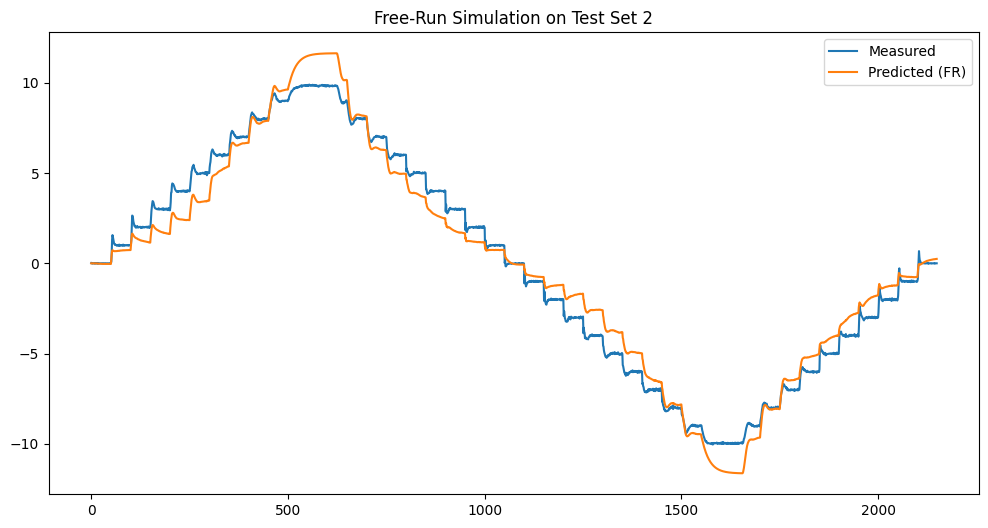

In [ ]:

y_hat_est_fr = mdl.predict(u_est, y_est, prediction_type='FR')
y_hat_test1_fr = mdl.predict(u_test1, y_test1, prediction_type='FR')
y_hat_test2_fr = mdl.predict(u_test2, y_test2, prediction_type='FR')

plt.figure(figsize=(12, 6))
plt.plot(y_est, label='Measured')
plt.plot(y_hat_est_fr, label='Predicted (FR)')
plt.title('Free-Run Simulation on Estimation Data')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test1, label='Measured')
plt.plot(y_hat_test1_fr, label='Predicted (FR)')
plt.title('Free-Run Simulation on Test Set 1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test2, label='Measured')
plt.plot(y_hat_test2_fr, label='Predicted (FR)')
plt.title('Free-Run Simulation on Test Set 2')
plt.legend()
plt.show()